In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.metrics import roc_auc_score
# import riiideducation
# from tqdm import tqdm

In [3]:
# 한글 깨짐 방지 코드
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system()=="Windows":
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings("ignore")

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
train = pd.read_csv('train.csv', nrows=10**6)
test = pd.read_csv("example_test.csv")
lectures = pd.read_csv("lectures.csv")
questions = pd.read_csv("questions.csv")

In [89]:
train_lec = train[train.content_type_id == 1]
TrLe=pd.merge(train_lec, lectures, left_on='content_id', right_on='lecture_id')

TrLe=TrLe[['timestamp','user_id','content_id','task_container_id','lecture_id','tag','part','type_of']]

In [194]:
train_que = train[train.content_type_id == 0]
TrQu=pd.merge(train_que, questions, left_on='content_id', right_on='question_id')
TrQu[['timestamp','user_id','content_id','task_container_id','user_answer','answered_correctly','prior_question_elapsed_time','prior_question_had_explanation','question_id','bundle_id','correct_answer','part','tags']]

,timestamp,user_id,content_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part,tags
0,0,115,5692,1,3,1,NaN,NaN,5692,5692,3,5,151
1,4216576228,24418,5692,497,3,1,21000.0,True,5692,5692,3,5,151
2,0,51285,5692,0,3,1,NaN,NaN,5692,5692,3,5,151
3,330907575,91216,5692,153,3,1,22000.0,True,5692,5692,3,5,151
4,560202977,138650,5692,122,3,1,18000.0,True,5692,5692,3,5,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...
980088,1369568376,19836663,12444,1700,3,1,14333.0,True,12444,12444,3,4,74 103 38
980089,449923902,19993962,3200,343,0,1,22000.0,True,3200,3198,0,4,161 67 81
980090,449923902,19993962,3199,343,1,1,22000.0,True,3199,3198,1,4,74 67 81
980091,449923902,19993962,3198,343,2,1,22000.0,True,3198,3198,2,4,106 67 81


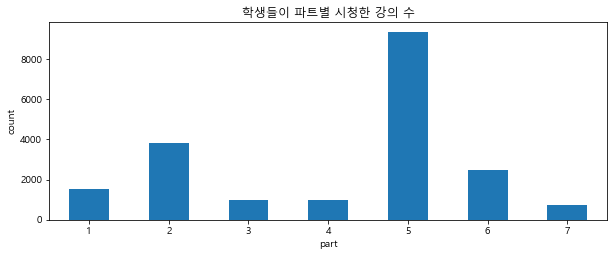

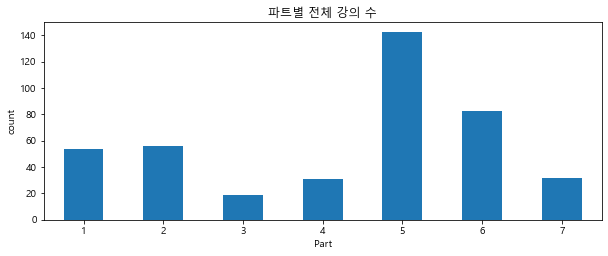

In [101]:
fig1 = plt.figure(figsize=(10,8))
ax1 = fig1.add_subplot(2,1,1)
ax1 = TrLe.groupby("part").count()['lecture_id'].plot.bar()
plt.title("학생들이 파트별 시청한 강의 수")
plt.xlabel("part")
plt.ylabel("count")
plt.xticks(rotation=0)

fig2 = plt.figure(figsize=(10,8))
ax2 = fig2.add_subplot(2,1,1)
ax2 = lectures.groupby("part").count()['lecture_id'].plot.bar()
plt.title("파트별 전체 강의 수")
plt.xlabel("Part")
plt.ylabel("count")
plt.xticks(rotation=0)

plt.show()

In [111]:
tmp=pd.DataFrame(TrLe.groupby("task_container_id").user_id.count()) #
tmp=tmp.reset_index(drop=False)
tmp

,task_container_id,user_id
0,2,2
1,5,1
2,7,3
3,8,6
4,9,6
...,...,...
3005,5001,1
3006,5014,1
3007,5018,1
3008,5022,1


In [150]:
bin_labels_20 = [int((len(TrLe)/20)*x) for x in range(1,21)]
tmp['ts_bin'] = pd.qcut(tmp['task_container_id'], q=20, labels=bin_labels_20)
tmp

,task_container_id,user_id,ts_bin
0,2,2,995
1,5,1,995
2,7,3,995
3,8,6,995
4,9,6,995
...,...,...,...
3005,5001,1,19907
3006,5014,1,19907
3007,5018,1,19907
3008,5022,1,19907


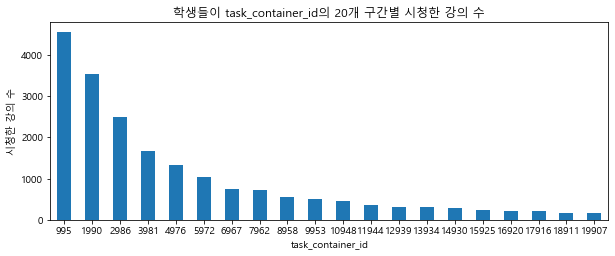

In [159]:
fig1=plt.figure(figsize=(10,8))
ax1 = fig1.add_subplot(2,1,1)
ax1 = tmp.groupby("ts_bin").sum()['user_id'].plot.bar()
plt.title("학생들이 task_container_id의 20개 구간별 시청한 강의 수")
plt.xlabel("task_container_id")
plt.ylabel("시청한 강의 수")
plt.xticks(rotation=0)
plt.show()

In [195]:
TrQu.user_id.nunique()

3824

In [190]:
tmp=pd.DataFrame(TrQu.groupby("user_id").task_container_id.max())
tmp=tmp.reset_index(drop=False)
tmp[:20]

,user_id,task_container_id
0,115,41
1,124,15
2,2746,19
3,5382,127
4,8623,99
5,8701,16
6,12741,105
7,13134,1045
8,24418,4889
9,24600,35


In [191]:
tmp=pd.DataFrame(tmp.groupby("task_container_id").user_id.count())
tmp=tmp.reset_index(drop=False)
tmp[:50]

,task_container_id,user_id
0,0,2
1,1,2
2,2,1
3,6,50
4,7,4
5,8,7
6,9,9
7,10,15
8,11,68
9,12,50


In [185]:
len(tmp)

731

In [186]:
bin_labels_20 = [int(731/20*x) for x in range(1,21)]
tmp['ts_bin'] = pd.qcut(tmp['task_container_id'], q=20, labels=bin_labels_20)
tmp

,task_container_id,user_id,ts_bin
0,0,1,36
1,1,1,36
2,2,1,36
3,6,1,36
4,7,1,36
...,...,...,...
726,5107,1,731
727,5261,1,731
728,5482,1,731
729,5630,1,731


In [187]:
tmp.groupby("ts_bin").sum()

,task_container_id,user_id
ts_bin,,
36,768,37
73,2146,37
109,3402,36
146,4847,37
182,6064,36
219,7680,37
255,8981,36
292,10988,37
328,12296,36


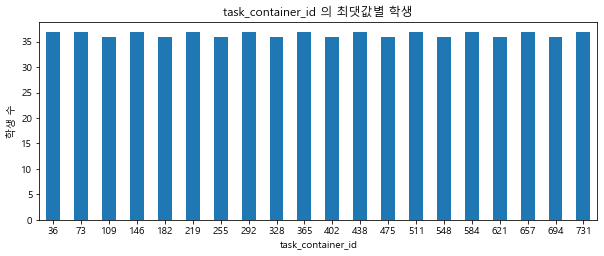

In [188]:
fig1=plt.figure(figsize=(10,8))
p = fig1.add_subplot(2,1,1)
p = tmp.groupby("ts_bin").sum()['user_id'].plot.bar()
plt.title("task_container_id 의 최댓값별 학생")
plt.xlabel("task_container_id")
plt.ylabel("학생 수")
plt.xticks(rotation=0)
plt.show()

In [120]:
TrQu.user_id.nunique()

3824

In [131]:
tmp.task_container_id.max()

5033